# Exam 2021 - Epidemic modelling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from scipy.optimize import bisect
from tqdm.notebook import trange

## Problem 2A: Deterministic SIR model

In [2]:
def Heun(y,n, h, N, beta, tau):
    yp = np.zeros_like(y[0])
    y = HeunInt(y,yp,n, h, N, beta, tau)
    return y

@jit(nopython = True)
def HeunInt(y,yp,n, h, N, beta, tau):
    for i in range(1,n+1):
        yp[:] = y[i-1,:] + h*df(h*(i-1),y[i-1,:],N, beta, tau)
        y[i,:] = y[i-1,:] + (h/2)*(df(h*(i-1),y[i-1,:],N, beta, tau) + df(h*i,yp,N, beta, tau))
    return y

In [3]:
#Defined the development
@jit(nopython = True) 
def df(t,y, N, beta, tau):
    dS = -beta*y[0]*y[1]/N
    dI = beta*y[0]*y[1]/N - y[1]/tau
    dR = y[1]/tau
    return np.array([dS,dI,dR])

def fSinf(x,Rnumber):
    return x - np.exp(-Rnumber*(1-x))

def fRinf(x,Rnumber):
    return x - (1 - np.exp(-Rnumber*x))

#### a)

In [4]:
tmax = 180   #days
h = 0.01
n = int(tmax/h)

beta = 0.25  #days
tau = 10     #days

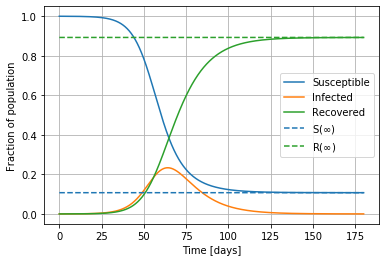

In [5]:
N = 1
RNumber = beta*tau
I0 = 1E-4
# y0 = [S0,I0,R0]
y0 = np.array([N-I0, I0, 0])
y = np.zeros((n+1,len(y0)))
y[0,:] = y0


tdSIR  = np.linspace(0,n*h,n+1)
ydSIR = Heun (y, n, h, N, beta, tau)
Sinf = bisect(fSinf,0,0.5,args=RNumber)
Rinf = bisect(fRinf,0.5,1,args=RNumber)

name = np.array(['Susceptible','Infected','Recovered','S($\infty$)','R($\infty$)'])

plt.plot(tdSIR,ydSIR)
plt.plot(tdSIR,Sinf*np.ones(n+1),'--',color = 'C0')
plt.plot(tdSIR,Rinf*np.ones(n+1),'--',color = 'C2')
plt.xlabel('Time [days]')
plt.ylabel('Fraction of population')
plt.legend(name)
plt.grid()
plt.savefig(f'P2Aa.pdf', format = 'pdf', dpi=300, bbox_inches='tight')
plt.show()

#### b)

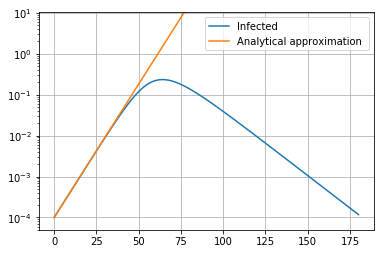

In [6]:
plt.plot(tdSIR,ydSIR[:,1], label = 'Infected')
plt.plot(tdSIR,ydSIR[0,1]*np.exp((beta-1/tau)*tdSIR),label = 'Analytical approximation ')
plt.yscale('log')
plt.ylim(5E-5,np.max(ydSIR[:,1])+10)
plt.legend()
plt.grid()
plt.savefig(f'P2Ab.pdf', format = 'pdf', dpi=300, bbox_inches='tight')
plt.show()

##### c)

Largest value of β: 0.228


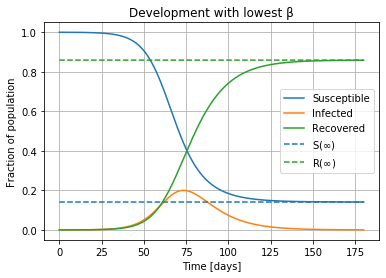

In [7]:
def fbeta(beta):
    return 0.2 - np.max(Heun(y, n, h, N, beta, tau)[:,1])


betamax = bisect(fbeta,0.1,0.3)
print(f'Largest value of β: {betamax:.3f}')


yd = Heun(y, n, h, N, betamax, tau)
name = np.array(['Susceptible','Infected','Recovered','S($\infty$)','R($\infty$)'])
plt.plot(tdSIR, yd)
RNumber = betamax*tau
Sinf = bisect(fSinf,0,0.5,args=RNumber)
Rinf = bisect(fRinf,0.5,1,args=RNumber)
plt.plot(tdSIR,Sinf*np.ones(n+1),'--',color = 'C0')
plt.plot(tdSIR,Rinf*np.ones(n+1),'--',color = 'C2')
plt.xlabel('Time [days]')
plt.ylabel('Fraction of population')
plt.title('Development with lowest β')
plt.legend(name)
plt.grid()
plt.show()

#### d)

Lowest fraction vaccinated 0.599


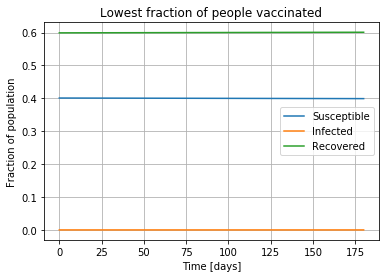

In [8]:
N = 1 
I0 = 1E-4
beta =0.25


def fR(R0):
    y0 = np.array([N-I0-R0, I0, R0])
    y = np.zeros((n+1,len(y0)))
    y[0,:] = y0
    return np.mean(np.gradient(Heun( y, n, h, N, beta, tau)[:,1]))



minR0 = bisect(fR,0.1,1)
print(f'Lowest fraction vaccinated {minR0:.3f}')
t  = np.linspace(0,n*h,n+1)
y0 = np.array([N-I0-minR0, I0, minR0])
y = np.zeros((n+1,len(y0)))
y[0,:] = y0
y = Heun( y, n, h, N, beta, tau)

name = np.array(['Susceptible','Infected','Recovered'])
plt.plot(t,y)
plt.xlabel('Time [days]')
plt.ylabel('Fraction of population')
plt.title('Lowest fraction of people vaccinated')
plt.legend(name)
plt.grid()
plt.show()

## Problem 2B: Stochastic SIR model

In [9]:
#Binomial distribution
@jit(nopython = True)
def BD(n,p):
    return np.random.binomial(n,p)

@jit(nopython = True)
def StorchasticSIR(y,n,h,N,beta,tau):
    PIR = 1 - np.exp(-h/tau)
    for i in range(1,n+1):
        PSI = 1 - np.exp(-h*beta*y[i-1,1]/N)
        deltaSI = BD(y[i-1,0],PSI)
        deltaIR = BD(y[i-1,1],PIR)
        y[i,0] = y[i-1,0] - deltaSI
        y[i,1] = y[i-1,1] + deltaSI - deltaIR
        y[i,2] = y[i-1,2] + deltaIR
    return y


def runMany(f,h,n,y,yd,N,beta,tau):
    Error = np.zeros(100)
    for i in range(100):
        ys = np.zeros((10,n+1,3))
        for j in range(10):
            ys[j] = f(y,n,h,N,beta,tau)
        ym = np.mean(ys,axis = 0)
        Error[i] = np.max(yd-ym)/N
    return np.mean(Error),np.std(Error)


def ErrorPlot(f,Tmax,h_vec,h_ref,y0,N,beta,tau):
    Error1 = np.zeros_like(h_vec)
    Error2 = np.zeros_like(h_vec)
    e = np.zeros_like(h_vec)
    n_ref = int(Tmax/h_ref)
    y = np.zeros((n_ref+1,3))
    y[0] = np.array([1-1E-4, 1E-4, 0])
    yd_ref = Heun(y,n_ref,h_ref, 1,beta,tau)
    for i,h in enumerate(h_vec):
        n = int(Tmax/h) 
        y = np.zeros((n+1,3))
        y[0] = np.array([1-1E-4, 1E-4, 0])
        yd = Heun(y,n,h, 1,beta,tau)
        nskip = int(n_ref/n)
        #Error in the deterministic SIR model
        Error1[i] = np.max(yd_ref[::nskip]-yd)
        
        y = np.zeros((n+1,len(y0)),dtype = int)
        y[0] = y0
        #Error in the stochastic SIR model
        Error2[i],e[i] = runMany(f,h,n,y,N*yd_ref[::nskip],N,beta,tau)
        
    fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (15,5))
    axes[0].set_title('Error in the deterministic SIR model')
    axes[1].set_title('Error in the stochastic SIR model')
    axes[0].plot(h_vec,Error1, marker = '.')
    axes[1].errorbar(h_vec,Error2,e)
    for a in axes:
        a.set_xlabel('Timesteps')
        a.set_xscale('log')
        a.set_yscale('log')
    axes[0].grid()
    plt.savefig(f'P2BError.pdf', format = 'pdf', dpi=300, bbox_inches='tight')
    plt.show()
    

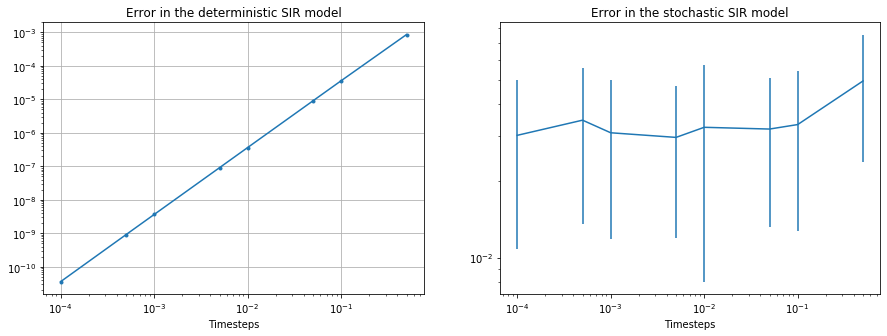

In [10]:
error_tmax = 100
beta = 0.25
N = 100000
I0 = 10
h_vec = np.array([1E-4,5E-4,1E-3,5E-3,0.01,0.05,0.1,0.5])
y0 = np.array([N-I0, I0, 0])
h_ref = 1E-5
ErrorPlot(StorchasticSIR,error_tmax,h_vec,h_ref,y0,N,beta,tau)

In [11]:
N = 100000
I0 = 10
# y0 = [S0,I0,R0]
y0 = np.array([N-I0, I0, 0])
y = np.zeros((n+1,len(y0)),dtype = int)
y[0] = y0
ts = np.zeros([10,n+1])
for i in range(10):
    ts[i]  = np.linspace(0,n*h,n+1)

ys = np.zeros([10,n+1,3])
for i in range(10):
    ys[i] = StorchasticSIR(y,n,h,N,beta,tau)
ym = np.mean(ys,axis = 0)

Nd = 1
I0d = 1E-4
# y0 = [S0,I0,R0]
y0d = np.array([Nd-I0d, I0d, 0])
yd = np.zeros((n+1,len(y0d)))
yd[0,:] = y0d
ydSIR = Heun (yd, n, h, Nd, 0.25, tau)

#### a)

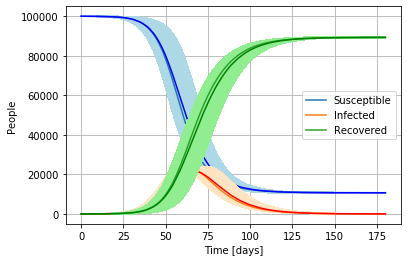

In [12]:
colors1 = np.array(['C0','C1','C2'])
colors2 = np.array(['b','r','g'])
colors3 = np.array(['lightblue','bisque','lightgreen'])
#Må finna ein bedre måte å plotta dette på
for i in range(3):
    plt.plot(ts,ys[:,:,i], color = colors3[i])
    plt.plot(tdSIR,N * ydSIR[:,i], label = name[i], color = colors1[i])
    plt.plot(tdSIR,ym[:,i],color = colors2[i])
 
plt.ylabel('People')
plt.xlabel('Time [days]')
plt.legend(loc = 'best')
plt.grid()
plt.savefig(f'P2Ba.pdf', format = 'pdf', dpi=300, bbox_inches='tight')
plt.show()

#### b)

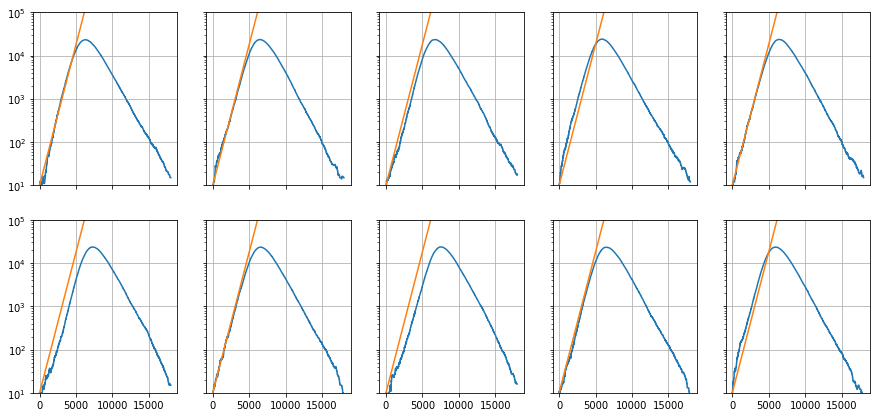

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7),sharex=True, sharey=True)
for i in range(10):
    axes[i//5,i%5].plot(ys[i,:,1])
    axes[i//5,i%5].plot(ys[i,0,1]*np.exp((beta-1/tau)*ts[i]))
    axes[i//5,i%5].grid()
axes[0,0].set_ylim(np.min(ys[0,:,1]),np.max(ys[:,:1])+10)
plt.yscale('log')

plt.savefig(f'P2Bb.pdf', format = 'pdf', dpi=300, bbox_inches='tight')
plt.show()

#### c)

In [14]:
@jit(nopython = True)
def ProbOutbreakSIR(f,y,n,h,N,args,numb):
    a = np.zeros(numb)
    for j in range(numb):
        infected = f(y,n,h,N,*args)[:,1]
        if np.max(infected)>50: #If outbrack the nr of infected 
            a[j]=1
    return a



I = np.arange(1,11)
S = np.zeros(10)
Uncertainty = np.zeros(10)
for i in I:
    y0 = np.array([N-i, i, 0])
    y = np.zeros((n+1,len(y0)),dtype = int)
    y[0] =y0
    a = ProbOutbreakSIR(StorchasticSIR,y,n,h,N,(beta,tau),1000)
    Uncertainty[i-1] = np.std(a)
    S[i-1] = np.mean(a)

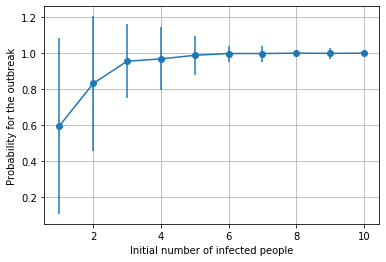

In [15]:
plt.errorbar(I,S,Uncertainty,fmt='-o')
plt.xlabel('Initial number of infected people')
plt.ylabel('Probability for the outbreak')
plt.grid()
plt.savefig(f'P2Bc.pdf', format = 'pdf', dpi=300, bbox_inches='tight')
plt.show()

## Problem 2C: Stochastic SEIIaR model

In [16]:
Tmax = 180   #days
h = 0.01
n = int(Tmax/h)

# Parameters from table 1
Beta = 0.55             #per day   
#r = [r_s,r_a]
R = np.array([1,0.1])
#f = [f_s,f_a]
F = np.array([0.6,0.4])
#tau = [tau_E,tau_I]
Tau = np.array([3,7])    #days

In [17]:
#Multinomial distribution
@jit(nopython = True)
def MD(n,p):
    return np.random.multinomial(n,p)

@jit(nopython = True)
def StorchasticSEIIaR(y,n,h,N,beta,r,f,tau):
    PEI = f[0] * (1-np.exp(-h/tau[0])) 
    PEIa = f[1] * (1-np.exp(-h/tau[0])) 
    PIR = 1 - np.exp(-h/tau[1])
    PIaR = PIR
    for i in range(1,n+1):
        PSE = 1 - np.exp(-h*beta* (r[0]*y[i-1,2]+r[1]*y[i-1,3])/N)
        deltaSE = BD(y[i-1,0],PSE)
        deltaEI,deltaEIa,deltaE = MD(y[i-1,1],(PEI,PEIa,1-PEI-PEIa))
        deltaIR = BD(y[i-1,2],PIR)
        deltaIaR = BD(y[i-1,3],PIaR)
        y[i,0] = y[i-1,0] - deltaSE                         #S
        y[i,1] = y[i-1,1] + deltaSE - deltaEI - deltaEIa    #E
        y[i,2] = y[i-1,2] + deltaEI - deltaIR               #I
        y[i,3] = y[i-1,3] + deltaEIa - deltaIaR             #Ia 
        y[i,4] = y[i-1,4] + deltaIR + deltaIaR
    return y

In [18]:
N = 100000
E0 = 25
# y0 = [S0,E0,I0,I0a,R0]
y0 = np.array([N-E0, E0, 0, 0 ,0])

In [19]:
#Find a good steplength
h_vec = [0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1]
h_ref = 1E-5
n_ref= int(100/h_ref)
y = np.zeros((n_ref+1,len(y0)),dtype = int)
y[0,:] = y0
ySEIIaR = np.zeros([10,n_ref+1,5])
for j in range(10):
    ySEIIaR[j] = StorchasticSEIIaR(y,n_ref,h_ref,N,Beta,R,F,Tau)

#calculate reference solution
ym_ref = np.mean(ySEIIaR,axis=0)

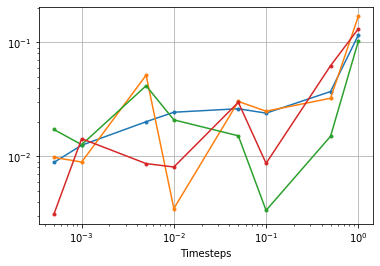

In [20]:
def ErrorSEIIar(h_vec,ym_ref,h_ref,n_ref):
    Error = np.zeros_like(h_vec) 
    for i,h in enumerate(h_vec):
        n = int(100/h)
        y = np.zeros((n+1,len(y0)),dtype = int)
        y[0,:] = y0

        ySEIIaR = np.zeros([10,n+1,5])

        for j in range(10):
            ySEIIaR[j] = StorchasticSEIIaR(y,n,h,N,Beta,R,F,Tau)
     
        ym = np.mean(ySEIIaR,axis=0)
        nskip = int(n_ref/n)
        Error[i] = np.max(ym_ref[::nskip]-ym)/N
    return Error


Error1 = ErrorSEIIar(h_vec,ym_ref,h_ref,n_ref)    
Error2 = ErrorSEIIar(h_vec,ym_ref,h_ref,n_ref)
Error3 = ErrorSEIIar(h_vec,ym_ref,h_ref,n_ref)
Error4 = ErrorSEIIar(h_vec,ym_ref,h_ref,n_ref)

plt.plot(h_vec,Error1,color = 'C0',marker = '.')
plt.plot(h_vec,Error2,color = 'C1',marker = '.')
plt.plot(h_vec,Error3,color = 'C2',marker = '.')
plt.plot(h_vec,Error4,color = 'C3',marker = '.')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Timesteps')
plt.grid()
plt.savefig(f'P2CError.pdf', format = 'pdf', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
N = 100000
E0 = 25
# y0 = [S0,E0,I0,I0a,R0]
y0 = np.array([N-E0, E0, 0, 0 ,0])

h=0.01
n = int(Tmax/h)

y = np.zeros((n+1,len(y0)),dtype = int)
y[0,:] = y0

ySEIIaR = np.zeros([10,n+1,5])
tSEIIaR = np.zeros([10,n+1])

for i in range(10):
    ySEIIaR[i] = StorchasticSEIIaR(y,n,h,N,Beta,R,F,Tau)
    tSEIIaR[i] = np.linspace(0,n*h,n+1)

    
Nd = 1
I0d = 1E-4
# y0 = [S0,I0,R0]
y0d = np.array([Nd-I0d, I0d, 0])
yd = np.zeros((n+1,len(y0d)))
yd[0,:] = y0d
ydSIR = Heun (yd, n, h, Nd, 0.25, tau)

#### a) 

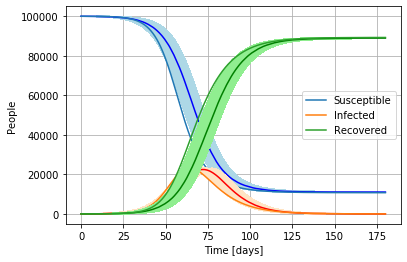

In [22]:
colors1 = np.array(['C0','C1','C2'])
colors2 = np.array(['b','r','g'])
colors3 = np.array(['lightblue','bisque','lightgreen'])

for i in range(3):
    if i==0:
        plt.plot(tSEIIaR,ySEIIaR[:,:,i], color = colors3[i])
        plt.plot(tdSIR,np.mean(ySEIIaR[:,:,i],axis = 0),color = colors2[i])
    elif i==1:
        I = ySEIIaR[:,:,i]+ySEIIaR[:,:,i+1]+ySEIIaR[:,:,i+2]
        plt.plot(tSEIIaR,I, color = colors3[i])
        plt.plot(tdSIR,np.mean(I,axis = 0),color = colors2[i])
    else:
        plt.plot(tSEIIaR,ySEIIaR[:,:,i+2], color = colors3[i])
        plt.plot(tdSIR,np.mean(ySEIIaR[:,:,i+2],axis = 0),color = colors2[i]) 
    plt.plot(tdSIR,N*ydSIR[:,i], label = name[i], color = colors1[i])
plt.ylabel('People')
plt.xlabel('Time [days]')
plt.legend(loc = "best") 
plt.grid()
plt.savefig(f'P2Ca.pdf', format = 'pdf', dpi=300, bbox_inches='tight')
plt.show()

#### b)

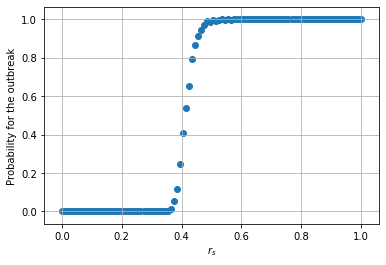

In [23]:
h = 0.1
n = int(Tmax/h)

Rs = np.linspace(0,1,100)
N = 100000
E0 = 25
# y0 = [S0,E0,I0,I0a,R0]
y0 = np.array([N-E0, E0, 0, 0 ,0])
y = np.zeros((n+1,len(y0)),dtype = int)
y[0,:] = y0
ra = 0.1

Outbreak = np.zeros(100,dtype = float)
for i,rs in enumerate(Rs):
    R = np.array([rs,ra])
    a = ProbOutbreakSIR(StorchasticSEIIaR,y,n,h,N,(Beta,R,F,Tau),1000)
    Outbreak[i] = np.mean(a)
plt.scatter(Rs,Outbreak)
plt.xlabel('$r_s$')
plt.ylabel('Probability for the outbreak')
plt.grid()
plt.savefig(f'P2Cb.pdf', format = 'pdf', dpi=300, bbox_inches='tight')
plt.show()

## Problem 2D: Stochastic SEIIaR commuter model

In [24]:
@jit(nopython = True) 
def MDvec(n,p):
    prob = np.zeros((len(n),3))
    for i,el in enumerate(n):
        prob[i] = np.random.multinomial(el,p)
    return prob[:,0],prob[:,1]

@jit(nopython = True) 
def BDvec(n,p):
    prob = np.zeros(len(n))
    for i,el in enumerate(n):
        prob[i] = np.random.binomial(el,p)
    return prob

@jit(nopython = True) 
def runtimestep(yk,n,h,N,beta,r,f,tau,towns):
   # sender inn y0 av y0i av folk i byen då 
    y = yk.copy()
    PEI = f[0] * (1-np.exp(-h/tau[0])) 
    PEIa = f[1] * (1-np.exp(-h/tau[0])) 
    PIR = 1 - np.exp(-h/tau[1])
    PIaR = PIR
    for i in range(1,n+1):
        I = np.sum(y[i-1,2])
        Ia = np.sum(y[i-1,3])
        people = np.sum(N)
        PSE = 1 - np.exp(-h*beta* (r[0]*I+r[1]*Ia)/people)
        deltaSE = BDvec(y[i-1,0],PSE)
        deltaEI,deltaEIa = MDvec(y[i-1,1],(PEI,PEIa,1-PEI-PEIa))
        deltaIR = BDvec(y[i-1,2],PIR)
        deltaIaR = BDvec(y[i-1,3],PIaR)
        y[i,0] = y[i-1,0] - deltaSE                         #S
        y[i,1] = y[i-1,1] + deltaSE - deltaEI - deltaEIa    #E
        y[i,2] = y[i-1,2] + deltaEI - deltaIR               #I
        y[i,3] = y[i-1,3] + deltaEIa - deltaIaR             #Ia 
        y[i,4] = y[i-1,4] + deltaIR + deltaIaR
    return y[1:]

           

def StorSEIIaRCom(Y0,n,h,N,beta,r,f,tau,towns):
    hdays = int(2*n*h)
    steps = int(n/hdays)
    Y = np.zeros((n+1,5,towns,towns),dtype = int)
    Y[0] = Y0
    #Assume that 2*n*h must be an integer
    for i in range(hdays):
        #Daytime
        if i%2:
            for town in range(towns):
                y = np.zeros((steps+1,5,towns),dtype = int)
                y[0] = Y[(i)*steps,:,:,town]
                Y[i*steps+1:(i+1)*steps+1,:,:,town] = runtimestep(y,steps,h,N[:,town],beta,r,f,tau,towns)
        
        #night-time
        else:
            for town in range(towns):
                y = np.zeros((steps+1,5,towns),dtype = int)
                y[0] = Y[(i)*steps,:,town]
                Y[i*steps+1:(i+1)*steps+1,:,town] = runtimestep(y,steps,h,N[town],beta,r,f,tau,towns)
    return Y

#### a)

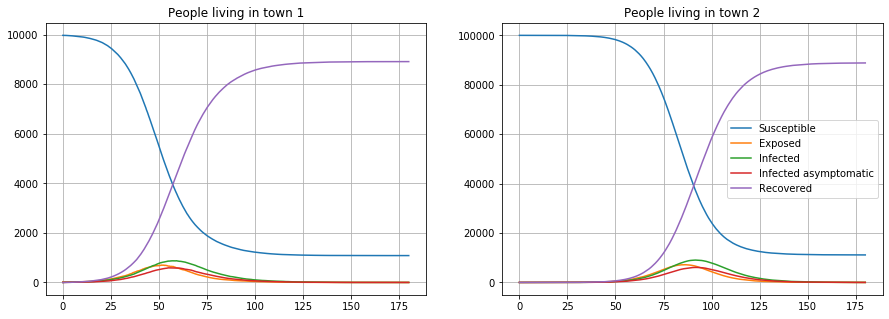

In [25]:
towns = 2

N = np.array([[9000,1000],
              [200, 99800]])

E0 = np.array([[25,0],[0,0]])
I0 = np.zeros_like(E0)
I0a = np.zeros_like(E0)
R0 = np.zeros_like(E0)

#Starts at night
# y0 = [S0,E0,I0,I0a,R0]
Y0 = np.array([N-E0,E0,I0,I0a,R0])


T = np.arange(0,Tmax+h,h)

YSEIIaR = np.zeros((10,n+1,5,towns,towns))

for i in range(10):
    YSEIIaR[i]= StorSEIIaRCom(Y0,n,h,N,Beta,R,F,Tau,towns)
    
    
Y= np.mean(YSEIIaR, axis=0)
fig,axes = plt.subplots(ncols = 2, nrows= 1, figsize=(15,5))
axes[0].set_title('People living in town 1')
axes[1].set_title('People living in town 2')
nameSEIIaR = np.array(['Susceptible','Exposed','Infected','Infected asymptomatic','Recovered'])

for i in range(5):
    axes[0].plot(T,Y[:,i,0,0]+Y[:,i,0,1],label = nameSEIIaR[i])
    axes[1].plot(T,Y[:,i,1,0]+Y[:,i,1,1],label = nameSEIIaR[i])
plt.legend()
axes[0].grid()
axes[1].grid()
plt.savefig(f'P2Da.pdf', format = 'pdf', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
towns = 2

N = np.array([[100000,0],
              [0, 10000]])

E0 = np.array([[25,0],[0,0]])
I0 = np.zeros_like(E0)
I0a = np.zeros_like(E0)
R0 = np.zeros_like(E0)
T = np.arange(0,Tmax+h,h)

#Starts at night
# y0 = [S0,E0,I0,I0a,R0]
Y0 = np.array([N-E0,E0,I0,I0a,R0])
#print(Y0)

YSEIIaR = np.zeros((10,n+1,5,towns,towns))

for i in range(10):
    YSEIIaR[i] = StorSEIIaRCom(Y0,n,h,N,Beta,R,F,Tau,towns)
    
Y = np.mean(YSEIIaR, axis=0)

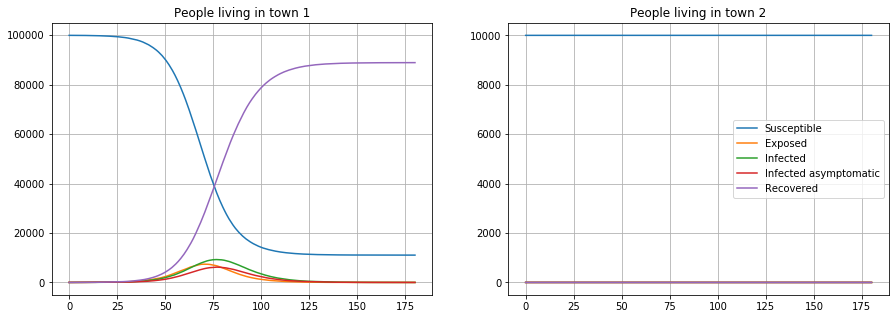

In [27]:
fig,axes = plt.subplots(ncols = 2, nrows= 1, figsize=(15,5))
axes[0].set_title('People living in town 1')
axes[1].set_title('People living in town 2')
nameSEIIaR = np.array(['Susceptible','Exposed','Infected','Infected asymptomatic','Recovered'])

for i in range(5):
    axes[0].plot(T,Y[:,i,0,0]+Y[:,i,0,1],label = nameSEIIaR[i])
    axes[1].plot(T,Y[:,i,1,0]+Y[:,i,1,1],label = nameSEIIaR[i])
axes[0].grid()
axes[1].grid()
plt.legend()
plt.show()

In [28]:
towns = 2

N = np.array([[0,100000],
              [10000, 0]])

E0 = np.array([[0,25],[0,0]])
I0 = np.zeros_like(E0)
I0a = np.zeros_like(E0)
R0 = np.zeros_like(E0)
T = np.arange(0,Tmax+h,h)

#Starts at night
# y0 = [S0,E0,I0,I0a,R0]
Y0 = np.array([N-E0,E0,I0,I0a,R0])
#print(Y0)

YSEIIaR = np.zeros((10,n+1,5,towns,towns))

for i in range(10):
    YSEIIaR[i] = StorSEIIaRCom(Y0,n,h,N,Beta,R,F,Tau,towns)
    
Y= np.mean(YSEIIaR, axis=0)

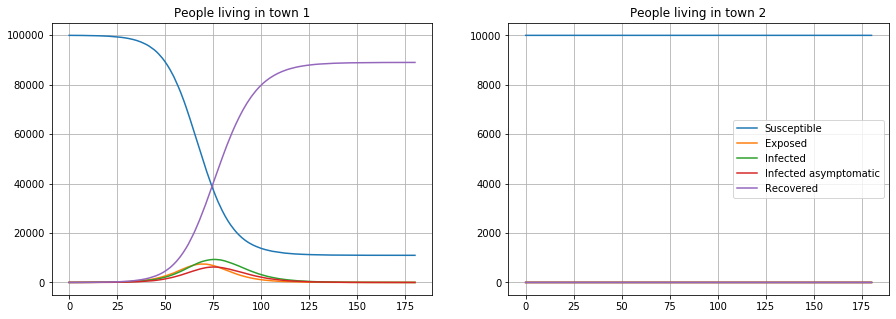

In [29]:
fig,axes = plt.subplots(ncols = 2, nrows= 1, figsize=(15,5))
axes[0].set_title('People living in town 1')
axes[1].set_title('People living in town 2')
nameSEIIaR = np.array(['Susceptible','Exposed','Infected','Infected asymptomatic','Recovered'])

for i in range(5):
    axes[0].plot(T,Y[:,i,0,0]+Y[:,i,0,1],label = nameSEIIaR[i])
    axes[1].plot(T,Y[:,i,1,0]+Y[:,i,1,1],label = nameSEIIaR[i])
axes[0].grid()
axes[1].grid()
plt.legend()
plt.show()

## Problem 2E: Larger stochastic SEIIaR commuter simulations

#### a)

In [30]:
towns = 10

N = np.array([[198600,100, 100, 100, 100, 1000,  0,    0,    0,    0     ],
              [500,   9500,0,   0,   0,   0,     0,    0,    0,    0     ],
              [500,   0,   9500,0,   0,   0,     0,    0,    0,    0     ],
              [500,   0,   0,   9500,0,   0,     0,    0,    0,    0     ],
              [500,   0,   0,   0,   9500,0,     0,    0,    0,    0     ],
              [1000,  0,   0,   0,   0,   498200,200,  200,  200,  200   ],
              [0,     0,   0,   0,   0,   1000,  19000,0,    0,    0     ],
              [0,     0,   0,   0,   0,   1000,  0,    19000,0,    0     ],
              [0,     0,   0,   0,   0,   1000,  0,    0,    19000,0     ],
              [0,     0,   0,   0,   0,   1000,  0,    0,    0    ,19000 ]])


E0 = np.zeros_like(N)
E0[0,0] = 25
I0 = np.zeros_like(N)
I0a = np.zeros_like(N)
R0 = np.zeros_like(N)
T = np.arange(0,Tmax+h,h)

#Starts at night
# y0 = [S0,E0,I0,I0a,R0]
Y0 = np.array([N-E0,E0,I0,I0a,R0])
#print(Y0)

YSEIIaR = np.zeros((10,n+1,5,towns,towns))

for i in range(10):
    YSEIIaR[i] = StorSEIIaRCom(Y0,n,h,N,Beta,R,F,Tau,towns)
    
Y = np.mean(YSEIIaR, axis=0)

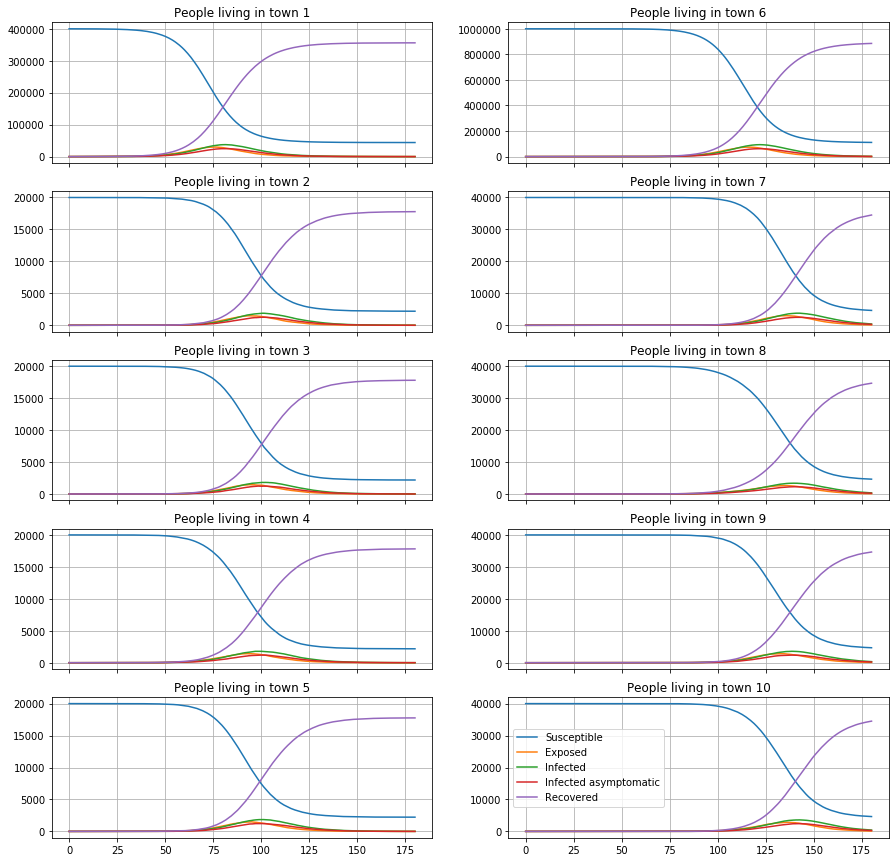

In [31]:
fig,axes = plt.subplots(ncols = 2, nrows= 5, figsize=(15,15),sharex=True)
nameSEIIaR = np.array(['Susceptible','Exposed','Infected','Infected asymptomatic','Recovered'])

for i in range(5):
    for j in range(10):
        axes[j%5,j//5].plot(T,np.sum(Y[:,i,j]+Y[:,i,j],axis=1),label = nameSEIIaR[i])

for i in range(10):
    axes[i%5,i//5].set_title(f'People living in town {i+1}')
    axes[i%5,i//5].grid()
plt.legend()
plt.savefig(f'P2Ea.pdf', format = 'pdf', dpi=300, bbox_inches='tight')
plt.show()

#### b)

In [32]:
#Function calulating how many town that has outbreak
@jit(nopython = True)
def CalOutbreak(I):
    outbreak = I>10
    Outb = np.sum(outbreak,axis = 1)
    return Outb
    


def SSC(Y0,n,h,N,beta,r,f,tau,towns):
    hdays = int(2*n*h)
    steps = int(n/hdays)
    Y = np.zeros((2*steps,5,towns,towns),dtype = int)
    Y[steps-1] = Y0
    Outbreak = np.zeros(n+1)
    If = np.sum(Y0[2]+Y0[3],axis=1)
    out = If>10
    Outbreak[0] = np.sum(out)
    y = np.zeros((steps+1,5,towns),dtype = int)
    Outbreak = SSCInte(Outbreak,Y,y,hdays,h,steps,N,beta,r,f,tau,towns)
    return Outbreak
    

@jit(nopython = True)
def SSCInte(Outbreak,Y,y,hdays,h,steps,N,beta,r,f,tau,towns):
    #Assume that 2*n*h must be an integer
    for i in range(hdays+1):
        #Day time
        if i%2:
            for town in range(towns):
                y[0] = Y[-1,:,:,town]
                Y[:steps,:,:,town] = runtimestep(y,steps,h,N[:,town],beta,r,f,tau,towns)
            I = np.sum(Y[:,2,:]+Y[:,3,:],axis=2)
            Outbreak[(i-1)*steps+1:(i+1)*steps+1] = CalOutbreak(I)
        
        #night time
        else:
            for town in range(towns):
                y[0] = Y[steps-1,:,town]
                Y[steps:,:,town] = runtimestep(y,steps,h,N[town],beta,r,f,tau,towns)
    return Outbreak

In [33]:
file = open("population_structure.csv")
N = np.loadtxt(file, delimiter=",")

In [34]:
Tmax = 180
h = 0.1
n = int(Tmax/h)

towns = np.shape(N)[0]


E0 = np.zeros_like(N)
E0[0,0] = 50
I0 = np.zeros_like(N)
I0a = np.zeros_like(N)
R0 = np.zeros_like(N)
T = np.arange(0,Tmax+h,h)

#Starts at night
# y0 = [S0,E0,I0,I0a,R0]
Y0 = np.array([N-E0,E0,I0,I0a,R0])

I = np.zeros((10,n+1))

for i in trange(10):
    I[i] = SSC(Y0,n,h,N,Beta,R,F,Tau,towns)
    
Imean = np.mean(I, axis=0)

In [35]:
def ReduceTravel(N):
    Nr = N.copy()
    for i in range(np.shape(Nr)[0]):
        red = 0.90*Nr[i]
        Nr[i] = 0.10*Nr[i]
        Nr[i,i] += np.sum(red)
    return Nr

In [36]:
rN =  ReduceTravel(N)
E0 = np.zeros_like(rN)
E0[0,0] = 50
I0 = np.zeros_like(rN)
I0a = np.zeros_like(rN)
R0 = np.zeros_like(rN)

#Starts at night
# y0 = [S0,E0,I0,I0a,R0]
Y0 = np.array([rN-E0,E0,I0,I0a,R0])

Ir = np.zeros((10,n+1))

for i in trange(10):
    Ir[i] = SSC(Y0,n,h,rN,Beta,R,F,Tau,towns)
    
Irmean = np.mean(Ir, axis=0)

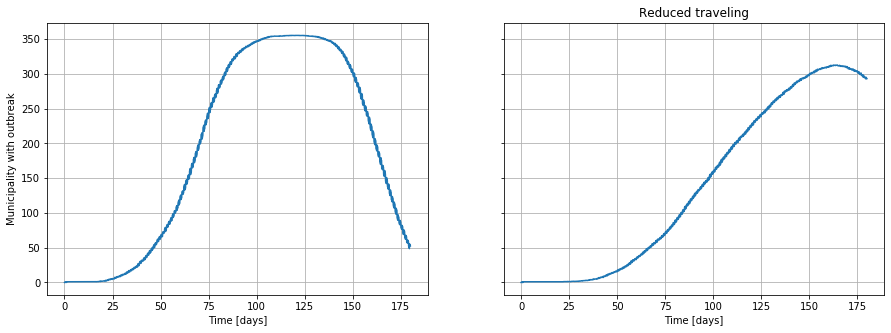

In [37]:
fig,axes = plt.subplots(ncols = 2, nrows= 1, figsize=(15,5),sharex=True,sharey=True)
axes[1].set_title('Reduced traveling')
axes[0].plot(T,Imean)
axes[1].plot(T,Irmean)
axes[0].set_ylabel('Municipality with outbreak')
axes[0].set_xlabel('Time [days]')
axes[1].set_xlabel('Time [days]')
axes[0].grid()
axes[1].grid()
plt.savefig(f'P2Eb.pdf', format = 'pdf', dpi=300, bbox_inches='tight')
plt.show()